<h1 style="text-align: center;">Data Visualization Project</h1>
<h2 style="text-align: center;">Using Hand Movements to Predict Interpersonal Physical Alignment</h2>

# Preface
* The hand movements data contains 12 different participants, 9 for training set and 3 for the test set.
* Each participant has 3 csv files with recorded hand movements, one for each alignment state.
* The three states are: Alone, Spontaneous and Sync.
> * Alone: The participants sat alone and were told to move their hands freely.
> * Spontaneous: The participants could see each other and were told to move their hands freely.
> * Sync: The participants could see each other and were told to synchronize their hand movements.
* The predicted labels are the states, making this a **multiclass classification** problem and a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore, also known as **offline/batch learning**.
* ***Main objective:*** Find the best algorithm and model parameters that correctly predict the state of the hand movements.

In [11]:
# common imports
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import joblib, glob
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn import clone  # 'clone' constructs a new unfitted estimator with the same parameters

# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [12]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [13]:
# display first 5 rows for a quick look
handright.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,0.270987,-0.017635,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,0.245085,-0.014770,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,0.230796,-0.008779,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,0.217681,-0.010759,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,0.220696,-0.017380,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [14]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [15]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [16]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [17]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [18]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: ID of the frame the hand belongs to
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow Pos (X, Y, Z): Position of the elbow
12. Grab Strength: The grab posture rating of the hand (values in range [0,1])
13. Grab Angle: The average angle of the fingers to the hand (0 to pi radians)
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip)
>
> ***X, Y, Z represent leap motion controller coordinates (see image below).***

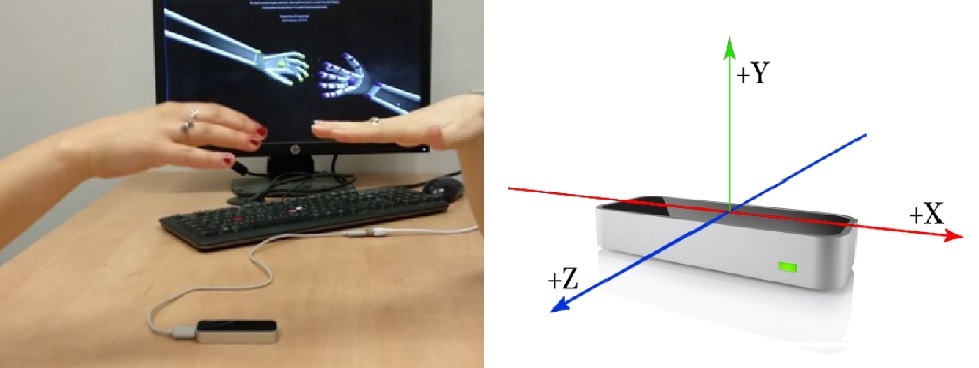

In [19]:
display.Image("extraFiles/leap.jpg")

##### Both images are from the academic article written about this experiment (listed as [1] in resources).

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [10]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [11]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
remove_first7(handright_prepared)  # right hand file without first 7 seconds

Before: (4812, 22)


In [12]:
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared[handright_prepared.isna().any(axis=1)].head()

Null values: 2304


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
3893,201.8797,23959,right,1,-8.565041,140.3621,112.05200,32.42480,-145.06130,-160.3878,1.188079,-2.793904,-0.139680,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0
3894,201.8968,23962,right,1,1.858126,112.7275,95.47443,497.33780,-642.50110,-686.8898,0.144945,0.010979,0.038722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.418411,0.0
3895,201.9134,23963,right,1,2.825271,112.5456,91.11944,112.62890,-21.18921,-507.1606,0.143836,-0.002969,0.067269,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.379807,0.0
3896,201.9300,23965,right,1,3.694190,113.4331,82.37254,61.92186,95.66204,-499.7987,0.157899,-0.025162,0.093537,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.523864,0.0
3897,201.9464,23967,right,1,5.272612,115.7207,73.13319,107.58490,139.81950,-569.6603,0.149520,-0.008641,0.075155,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.715370,0.0


In [13]:
handright_prepared.dropna(inplace=True)
print("Null values:", handright_prepared.isna().sum().sum())
print("After:", handright_prepared.shape)
handright_prepared.head()

Null values: 0
After: (3893, 22)


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


> The following functions load the data into a DataFrame:

In [14]:
# function combines alone csv file with the right hand file

def combine_right(df_alone):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand prevents harming the DataFrame since it is used multiple times
    right = handright_prepared.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [15]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    merged = left.merge(right, how="outer", on=["state", "time"])
    # adds a column with the second
#    merged.insert(1, "round_time", merged.time.astype(int) - merged.time.min().astype(int))
    merged.insert(1, "round_time", merged.time.round(2))
    # return first frame per rounded millisecond
    return merged.groupby("round_time").mean().reset_index(drop=True) # round time is the index after groupby

alone = pd.read_csv(r"extraFiles/Training/Evyatar Cohen/Evyatar636771054555711409Alone.csv")
alone_new = combine_right(alone)
alone_new.insert(1, "state", 0)
alone_newnew = transform_columns(alone_new)
alone_newnew

alone2 = pd.read_csv(r"extraFiles/Training/Yael Hagai/Yael636771061659067649Alone.csv")
alone2_new = combine_right(alone2)
alone2_new.insert(1, "state", 0)
alone2_newnew = transform_columns(alone2_new)
alone2_newnew

rightcols = alone_newnew.filter(regex="right").columns.tolist()
rightcols

alone_newnew

alone_newnew[rightcols]

alone2_newnew[rightcols]

> Rescaling the times in round time to start from zero rather than rounding the time values can create more diverse
> samples for each second. This is especially important for the 'alone' state, where the right hand is concatenated from
> the same file.

In [16]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            df = combine_right(df)
            df.insert(0, "state", 0)
        elif "Spontan" in filename:
            df.insert(0, "state", 1)
        elif "Sync" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=True)
    return data

In [17]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [18]:
# display loaded data
train_set.head()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,1.0,343.0061,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.006620,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752
1,1.0,343.0227,-103.8721,201.4944,-2.063620,-178.50250,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.545550,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.000000,2.704073,0.293775
2,1.0,343.0392,-106.3691,207.4667,-2.337110,-126.78780,318.5284,-12.872290,1.441357,0.489946,1.496526,-168.4939,174.6985,-3.134404,-316.4541,-28.81729,-1.155143,0.0,1.865896,0.0,151.4056,203.4883,-38.14280,-14.11075,-56.448120,68.092860,0.637780,-0.134837,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.3746,1.000000,2.422549,0.175940
3,1.0,343.0558,-107.9509,212.1324,-2.788956,-74.28078,244.4823,-30.771300,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.0,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.234860,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.14600,161.7030,1.000000,2.101400,0.052777
4,1.0,343.0723,-109.5427,216.8003,-3.337280,-96.49666,269.5434,-37.723870,1.431969,0.488396,1.491886,-171.4205,183.7144,-4.797314,-311.4874,-25.01130,-16.183130,0.0,1.950082,0.0,152.4920,202.8671,-36.85715,57.06179,4.746809,17.712610,0.568949,-0.165198,-0.553877,192.5801,172.1215,12.837430,325.7650,19.51061,162.1241,0.849696,1.878483,0.000000


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [19]:
hands = train_set.copy()

In [20]:
hands.head(2)

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,1.0,343.0061,-102.2870,198.3166,-2.122641,-174.5721,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
1,1.0,343.0227,-103.8721,201.4944,-2.063620,-178.5025,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.0,2.704073,0.293775


In [21]:
hands.shape

(102167, 38)

In [22]:
# check if time and state are related
hands.sort_values("time").loc[800:850, ["state", "time"]]

,state,time
800,1.0,356.2594
40419,0.0,356.2674
91559,2.0,356.2758
801,1.0,356.2761
40420,0.0,356.2840
...,...,...
91607,2.0,357.0714
849,1.0,357.0715
40468,0.0,357.0793
91608,2.0,357.0876


In [23]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102167 entries, 0 to 102166
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   state                 102167 non-null  float64
 1   time                  102167 non-null  float64
 2   position_x_left       102167 non-null  float64
 3   position_y_left       102167 non-null  float64
 4   position_z_left       102167 non-null  float64
 5   velocity_x_left       102167 non-null  float64
 6   velocity_y_left       102167 non-null  float64
 7   velocity_z_left       102167 non-null  float64
 8   pitch_left            102167 non-null  float64
 9   roll_left             102167 non-null  float64
 10  yaw_left              102167 non-null  float64
 11  wrist_pos_x_left      102167 non-null  float64
 12  wrist_pos_y_left      102167 non-null  float64
 13  wrist_pos_z_left      102167 non-null  float64
 14  elbow_pos_x_left      102167 non-null  float64
 15  

In [24]:
# check for null values
hands.isna().sum().sum()

0

In [25]:
# summary of the numerical attributes
# null values are ignored
hands.describe()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
count,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000,102167.000000
mean,1.001008,530.008960,-108.399969,203.950690,33.658825,0.106481,-1.128087,0.126286,1.012147,0.748588,1.117443,-150.022211,165.290776,41.313122,-313.367382,4.700229,73.416430,0.118788,0.832527,0.197191,92.716621,214.472398,38.867510,-0.096691,-1.373416,0.967838,0.811813,-0.638649,-0.676893,124.418872,175.754989,73.008099,266.244544,26.265034,186.893617,0.068127,0.524542,0.058112
std,0.815742,138.724538,52.362851,53.346913,55.405094,137.080996,209.651380,130.074743,0.945446,1.083639,0.869910,48.650688,48.950463,48.394754,61.070479,69.563213,65.676440,0.284081,0.919241,0.338187,65.185909,54.310437,55.124203,159.584300,263.757479,182.103616,0.603547,0.671415,0.622983,73.386176,49.679981,55.406928,98.304482,61.711742,101.964333,0.220318,0.693217,0.200084
min,0.000000,182.549200,-332.468400,46.700040,-175.192200,-2946.061000,-2549.699000,-4198.832000,-3.141397,-3.141498,-3.140881,-358.100700,-12.279810,-134.610200,-527.991100,-227.942600,-196.431400,0.000000,0.000000,0.000000,-871.496500,59.404940,-154.681500,-1997.961000,-3180.031000,-2419.239000,-3.139637,-3.138914,-3.116449,-897.085900,9.248903,-135.556000,-857.703900,-209.569100,-78.658120,0.000000,0.000000,0.000000
25%,0.000000,429.381000,-136.316350,167.599350,1.667917,-66.072265,-105.709350,-57.821390,0.664863,0.236738,0.774440,-177.818900,133.512600,13.102065,-353.121350,-41.125215,23.831945,0.000000,0.001525,0.000000,35.526975,178.764800,-0.594741,-54.894200,-118.661800,-75.494435,0.419063,-1.111792,-1.143564,52.163440,146.820550,31.128990,174.330100,-15.306375,103.456150,0.000000,0.053431,0.000000
50%,1.000000,532.579300,-103.385000,201.296700,33.615700,-1.970494,1.018222,1.701208,1.261354,0.892743,1.284521,-145.463300,160.501100,39.378630,-314.022800,-2.993422,70.696160,0.000000,0.532742,0.000000,111.436600,211.420600,36.915400,1.067476,-0.710156,-2.551122,0.795458,-0.624489,-0.577206,151.056400,169.596200,73.241740,295.458800,20.062220,165.764000,0.000000,0.277214,0.000000
75%,2.000000,631.065250,-76.851930,234.619850,66.620345,63.697845,107.884050,60.316635,1.602624,1.367630,1.608865,-116.354400,188.816500,66.953700,-275.624200,40.108850,123.431600,0.000000,1.307195,0.291127,143.423950,244.546100,71.242350,58.380705,116.505900,73.089020,1.272510,-0.050637,-0.157743,183.879600,199.072150,114.601850,345.523950,62.208960,277.035450,0.000000,0.665831,0.000000
max,2.000000,856.329500,73.487510,517.504200,276.203200,3735.420000,2775.949000,2460.510000,3.140658,3.141574,3.141453,22.004390,454.275400,250.608700,146.564800,459.916300,378.241500,1.000000,3.141593,1.000000,269.368900,585.819200,260.237800,1147.957000,1540.136000,1279.244000,3.136825,3.134909,3.123079,291.070900,595.047800,316.406300,503.926100,404.511100,518.593100,1.000000,3.141593,1.000000


In [26]:
hands.state.value_counts().sort_index()

0.0    33941
1.0    34182
2.0    34044
Name: state, dtype: int64

time_diff = hands.time.diff()
hands["time_diff"] = time_diff
#hands = pd.concat([hands, time_diff], axis=1)
#hands.isna().sum()
hands.isna().sum()

> Observations:
* The state and time are not related. The time relationship is per file, since the order of events is
crucial in time series data. In other words, the motion at time x is related to the motion at time x+1.
* The features have very different scales.
* There are no missing values.
* The number of rows per state is imbalanced.

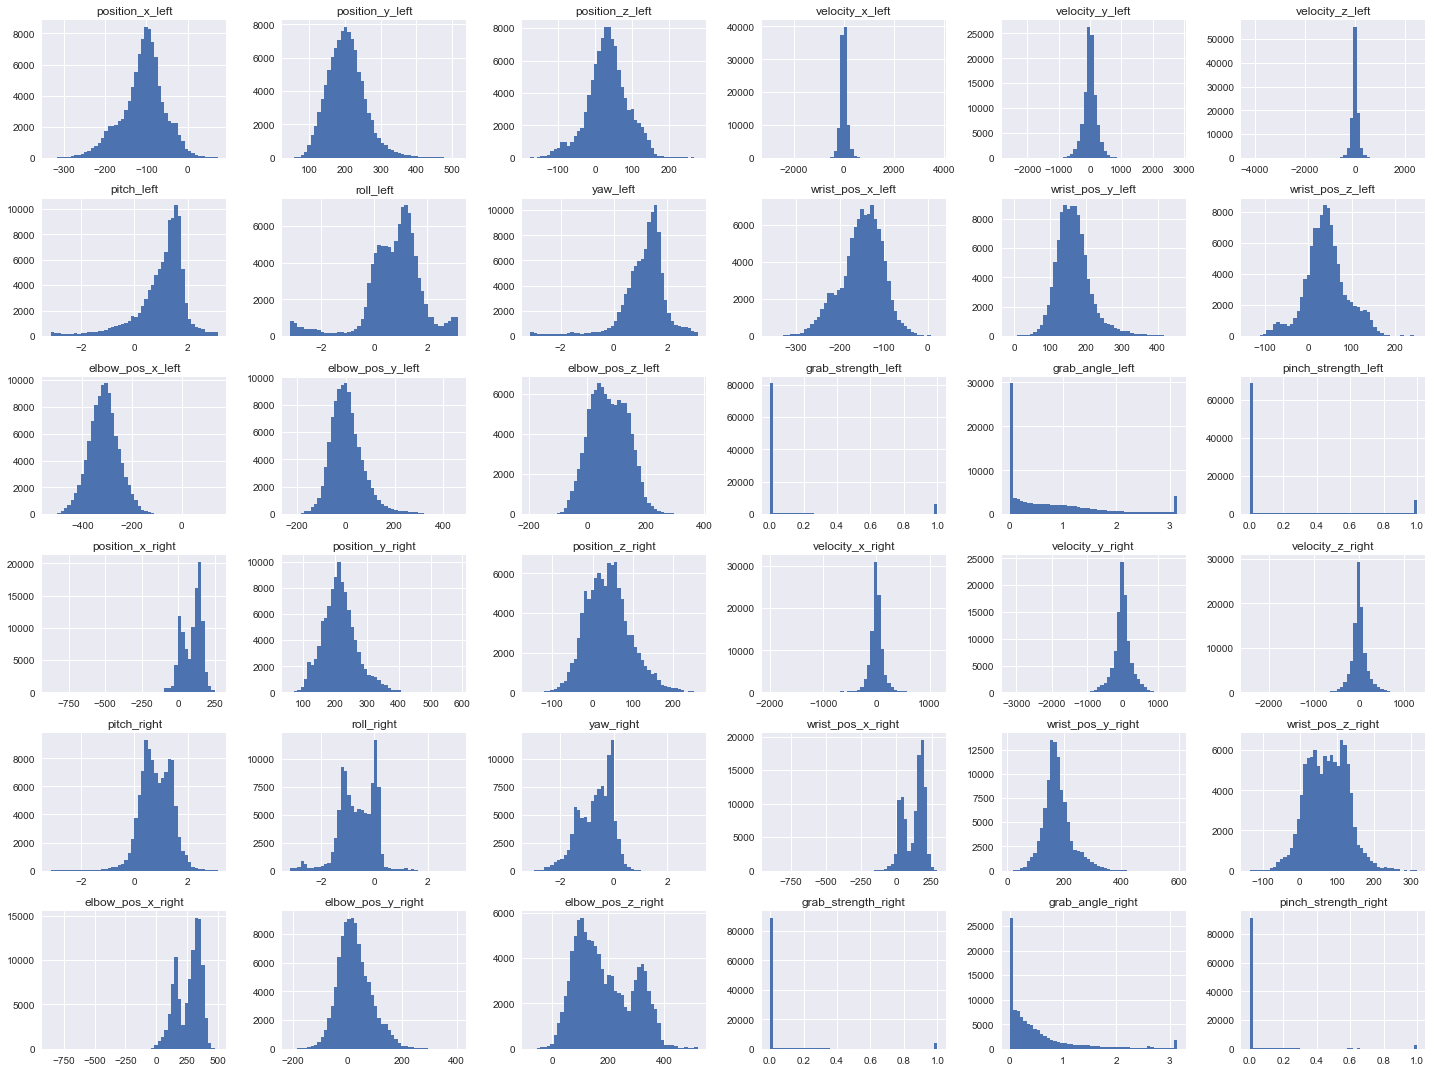

In [27]:
# histogram plot
hands.drop(["state", "time"], axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

state_groups = hands.drop("time", axis=1, inplace=False).groupby("state")

state_groups.get_group(0).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="red")
plt.suptitle("Alone", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(1).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color='orange')
plt.suptitle("Spontaneous", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(2).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="green")
plt.suptitle("Sync", size=25)
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

> ### Looking for Correlations:
> Correlations measure the linear relationships between the features.
> A strong positive correlation is close to 1 and a strong negative correlation is close to -1.
> Looking for correlations with the 'state' column can emphasize which features are most significant.

In [28]:
corr_matrix = hands.corr()
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.704190
wrist_pos_x_right       0.633941
position_x_right        0.583797
pitch_right             0.443479
roll_left               0.236340
pitch_left              0.173256
position_y_right        0.159048
time                    0.157385
position_z_left         0.154817
wrist_pos_z_left        0.139850
position_y_left         0.068069
wrist_pos_y_right       0.010212
velocity_y_right        0.001125
velocity_x_right       -0.000678
velocity_x_left        -0.001200
velocity_z_left        -0.002106
velocity_y_left        -0.003399
velocity_z_right       -0.006897
grab_strength_right    -0.009337
position_z_right       -0.009977
elbow_pos_z_left       -0.023662
yaw_left               -0.025466
elbow_pos_x_left       -0.068127
pinch_strength_right   -0.082245
wrist_pos_y_left       -0.104195
grab_strength_left     -0.131352
grab_angle_right       -0.164310
pinch_strength_left    -0.164806
wrist_pos_x_left       -0.215626
grab_angle

> Observations:
* From looking at the values, clearly the right hand has a greater influence than the left.
An assumption can be made that using the same right-hand data for all the 'alone' state files had an influence
on the right-hand correlations.
* Velocity has a low correlation for both hands and all three planes.
* Pinch and grab strength

> ### Evaluating Feature Combinations

> #### Combining position and wrist pos columns (by plane and hand type):

In [29]:
pos_df = hands.filter(regex="wrist_pos|position")
pos_left = pos_df.filter(regex="left").columns.tolist()
pos_right = pos_df.filter(regex="right").columns.tolist()

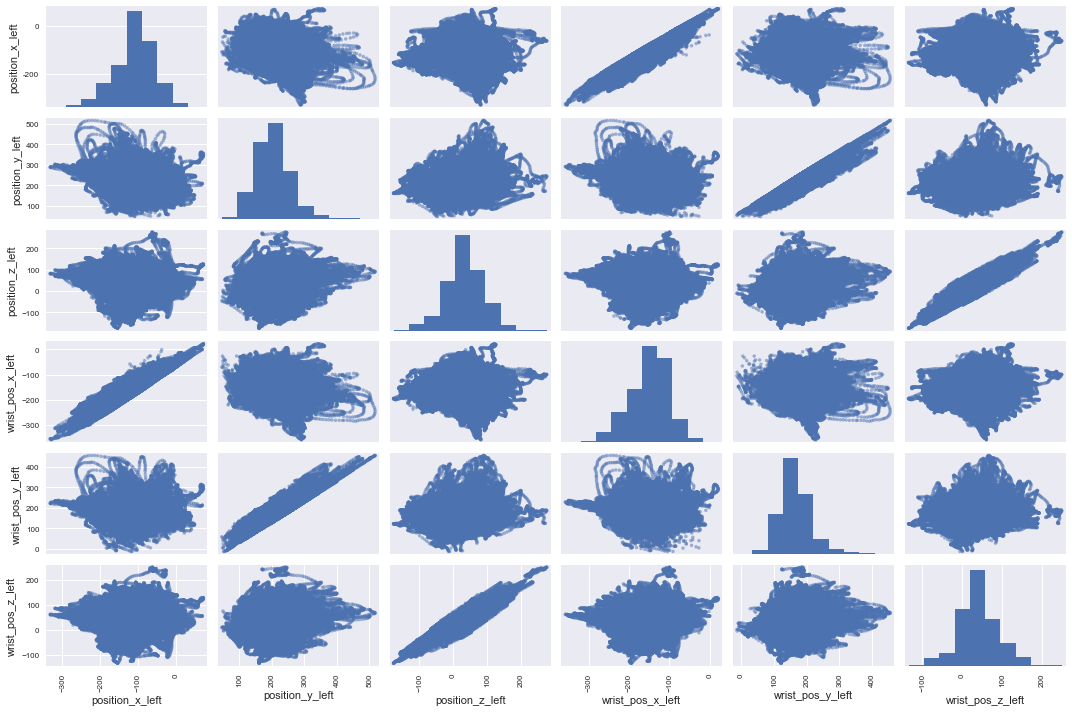

In [30]:
scatter_matrix(hands[pos_left], figsize=(15, 10))
plt.tight_layout()
plt.show()

In [31]:
hands.groupby("state")[pos_left].agg(["mean", "min", "max"]).T

state                         0.0         1.0         2.0
position_x_left  mean  -81.912711 -120.332728 -122.825961
                 min  -275.933800 -319.316100 -332.468400
                 max    73.487510  -18.003330   -7.937304
position_y_left  mean  203.212650  196.562802  212.104333
                 min    46.700040   50.638620   48.593610
                 max   468.507500  479.818400  517.504200
position_z_left  mean   18.774990   42.302948   39.818466
                 min  -175.192200 -101.933700 -118.044800
                 max   276.203200  211.484000  178.961600
wrist_pos_x_left mean -128.972506 -166.247687 -154.716983
                 min  -265.462000 -350.942300 -358.100700
                 max    22.004390  -52.850380  -26.513340
wrist_pos_y_left mean  173.003880  162.408946  160.494520
                 min    20.379230  -12.279810    4.404150
                 max   447.871900  439.640000  454.275400
wrist_pos_z_left mean   27.918165   51.412721   44.527015
                 min  -134.610200  -84.337100  -85.494260
                 max   250.608700  193.700600  188.292500

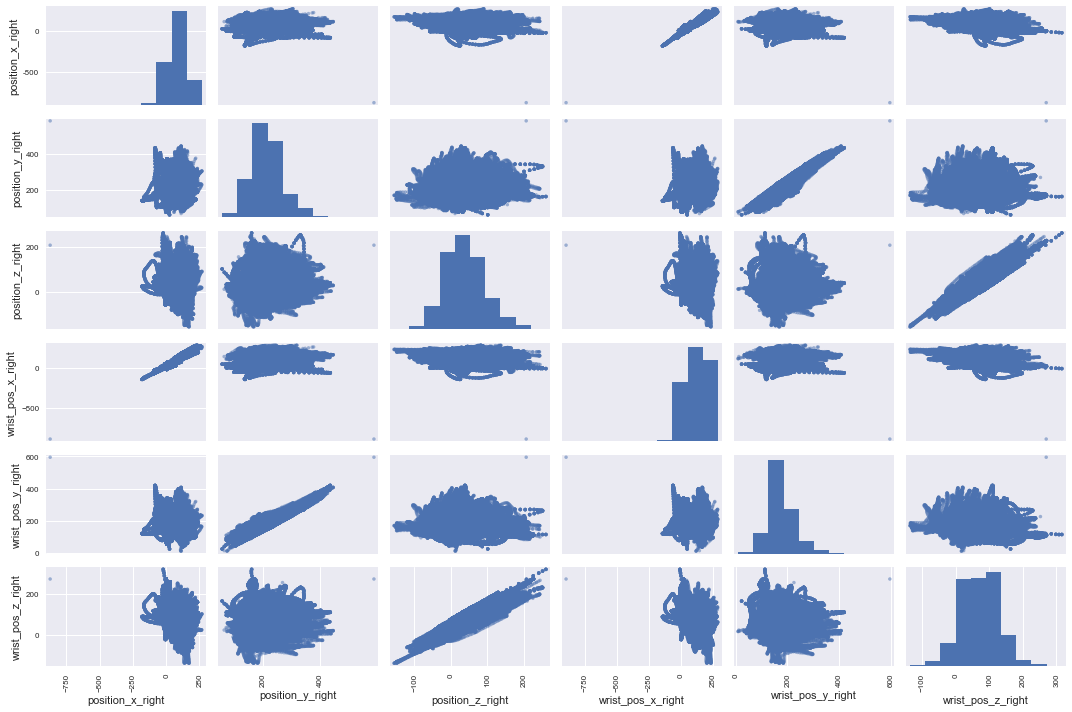

In [32]:
scatter_matrix(hands[pos_right], figsize=(15, 10))
plt.tight_layout()
plt.show()

In [33]:
hands.groupby("state")[pos_right].agg(["mean", "min", "max"]).T

state                          0.0         1.0         2.0
position_x_right  mean   21.250988  141.855245  114.628224
                  min  -180.878400 -871.496500  -82.386260
                  max   241.939500  258.442700  269.368900
position_y_right  mean  202.283158  217.618309  223.466098
                  min    59.404940   66.433570   86.732880
                  max   434.498400  585.819200  437.697900
position_z_right  mean   42.442069   33.109755   41.084861
                  min   -56.885730 -154.681500 -119.367700
                  max   260.237800  243.283800  244.340100
wrist_pos_x_right mean   36.981919  184.630586  151.135497
                  min  -142.189800 -897.085900  -53.715980
                  max   219.866800  289.153300  291.070900
wrist_pos_y_right mean  172.262127  181.454446  173.514722
                  min    23.062180    9.248903   33.117910
                  max   419.043400  595.047800  404.431100
wrist_pos_z_right mean  104.311193   58.667791   56.198151
                  min   -20.995500 -135.556000  -81.525660
                  max   316.406300  269.970700  263.599500

> Looking at the values that match each position according to hand type and plane, it looks like the
> values are roughly in the same range. This means that the attribute combinations can be tested
> without normalizing beforehand.
>
> I will try combining the position features by plane and hand type into one by calculating the mean, a total of
> 6 new features.

In [34]:
# compute the mean into a new column

hands["mean_pos_x_left"] = (hands["wrist_pos_x_left"] + hands["position_x_left"]) / 2
hands["mean_pos_y_left"] = (hands["wrist_pos_y_left"] + hands["position_y_left"]) / 2
hands["mean_pos_z_left"] = (hands["wrist_pos_z_left"] + hands["position_z_left"]) / 2

hands["mean_pos_x_right"] = (hands["wrist_pos_x_right"] + hands["position_x_right"]) / 2
hands["mean_pos_y_right"] = (hands["wrist_pos_y_right"] + hands["position_y_right"]) / 2
hands["mean_pos_z_right"] = (hands["wrist_pos_z_right"] + hands["position_z_right"]) / 2

In [35]:
pos_cols = hands.filter(regex="wrist_pos|position|mean_pos").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right',
 'mean_pos_x_left',
 'mean_pos_y_left',
 'mean_pos_z_left',
 'mean_pos_x_right',
 'mean_pos_y_right',
 'mean_pos_z_right']

In [36]:
corr_matrix = hands.corr()
corr_matrix["state"][pos_cols].sort_values(ascending=False)

wrist_pos_x_right    0.633941
mean_pos_x_right     0.614825
position_x_right     0.583797
position_y_right     0.159048
position_z_left      0.154817
mean_pos_z_left      0.151246
wrist_pos_z_left     0.139850
mean_pos_y_right     0.089839
position_y_left      0.068069
wrist_pos_y_right    0.010212
position_z_right    -0.009977
mean_pos_y_left     -0.014816
wrist_pos_y_left    -0.104195
mean_pos_z_right    -0.188648
wrist_pos_x_left    -0.215626
mean_pos_x_left     -0.275024
position_x_left     -0.318545
wrist_pos_z_right   -0.354017
Name: state, dtype: float64

> Observations:
* Overall, it seems that the new columns represent the correlation well.
It will be useful to implement a transformer for this to easily evaluate the results during model training.
* This feature combination could possibly be used instead of the original features, which would reduce
dimensionality a bit.

> #### Combining grab strength and angle columns:

In [37]:
# get list of column names
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right']

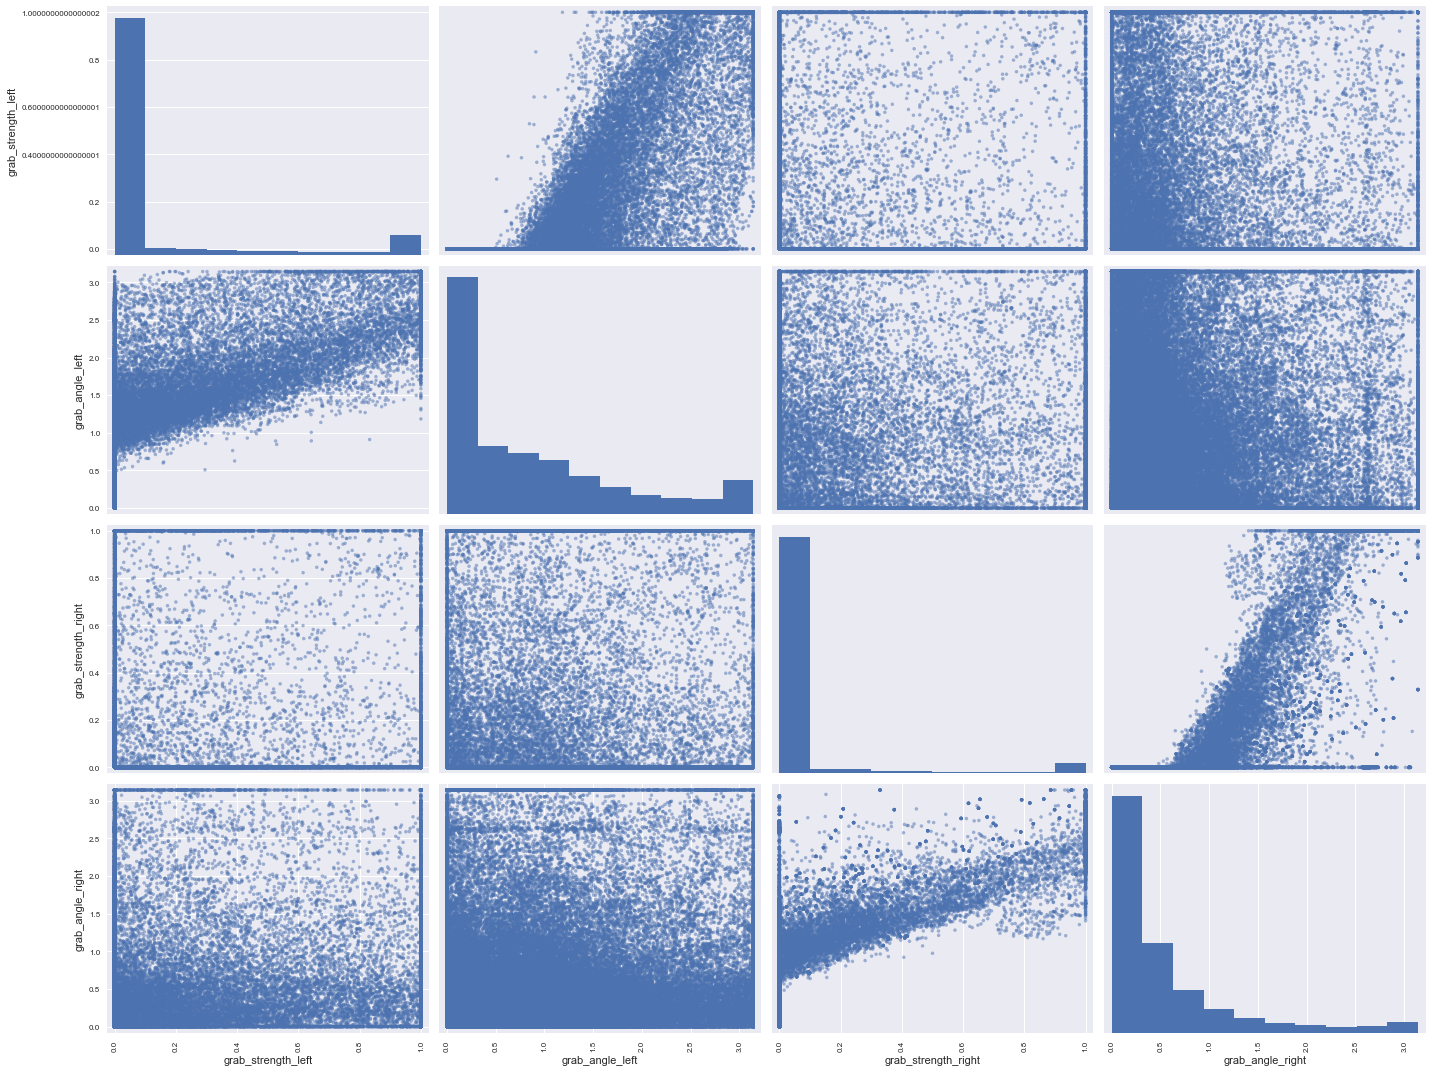

In [38]:
# plot correlation matrix
scatter_matrix(hands[grab_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

> There is a pretty strong correlation between the grab angle and strength for each hand type.

In [39]:
# aggregate columns by alignment state
hands.groupby("state")[grab_cols].agg(["mean", "min", "max"]).T

state                          0.0       1.0       2.0
grab_strength_left  mean  0.160203  0.127522  0.068730
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_left     mean  1.040612  0.974195  0.482830
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593
grab_strength_right mean  0.072233  0.064989  0.067185
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_right    mean  0.651648  0.549835  0.372426
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593

> It is clear that strength is a value between 0 and 1 and the angle is between 0 and pi.
> In order to combine these features, I will first normalize the angle range to 0 and 1,
> then compute the mean, adding 2 new columns.

In [40]:
# normalize angle values to the same scale as grab strength
# angle = [0, pi], grab strength = [0, 1]
grab_angle_left_norm = hands["grab_angle_left"] / hands["grab_angle_left"].max()
grab_angle_right_norm = hands["grab_angle_right"] / hands["grab_angle_right"].max()

# compute the mean into a new column
hands["grab_left"] = (hands["grab_strength_left"] + grab_angle_left_norm) / 2
hands["grab_right"] = (hands["grab_strength_right"] + grab_angle_right_norm) / 2

In [41]:
# get list with added columns
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right',
 'grab_left',
 'grab_right']

In [42]:
# show correlation with added columns
corr_matrix = hands.corr()
corr_matrix["state"][grab_cols].sort_values(ascending=False)

grab_strength_right   -0.009337
grab_right            -0.091360
grab_strength_left    -0.131352
grab_angle_right      -0.164310
grab_left             -0.201817
grab_angle_left       -0.247586
Name: state, dtype: float64

> Observations:
* While grab left seems to provide a seemingly high correlation, grab right very little correlation
compared to grab angle right, which is a lot more correlated.
* Grab strength right has a positive correlation, unlike grab angle right and the newly combined feature, grab right.
* Overall, it seems that the new features mostly cause information loss and don't provide much more information
(especially the grab right feature, which is hardly correlated).
Therefore, I will not use it for further analysis.

In [43]:
# drop the combined feature columns
hands.drop(["grab_left", "grab_right"], axis=1, inplace=True)

> Taking another look at the correlations:

In [44]:
corr_matrix = hands.corr()
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.704190
wrist_pos_x_right       0.633941
mean_pos_x_right        0.614825
position_x_right        0.583797
pitch_right             0.443479
roll_left               0.236340
pitch_left              0.173256
position_y_right        0.159048
time                    0.157385
position_z_left         0.154817
mean_pos_z_left         0.151246
wrist_pos_z_left        0.139850
mean_pos_y_right        0.089839
position_y_left         0.068069
wrist_pos_y_right       0.010212
velocity_y_right        0.001125
velocity_x_right       -0.000678
velocity_x_left        -0.001200
velocity_z_left        -0.002106
velocity_y_left        -0.003399
velocity_z_right       -0.006897
grab_strength_right    -0.009337
position_z_right       -0.009977
mean_pos_y_left        -0.014816
elbow_pos_z_left       -0.023662
yaw_left               -0.025466
elbow_pos_x_left       -0.068127
pinch_strength_right   -0.082245
wrist_pos_y_left       -0.104195
grab_stren

# 3. Data Cleaning

In [45]:
# clean copy of the training set
df = train_set.copy()

In [46]:
# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, combine_position_wrist=False):
        self.combine_position_wrist = combine_position_wrist

    def fit(self, X, y=None):
        return self # no fitting needed

    def transform(self, X):
        mean_pos_x_left = (X["wrist_pos_x_left"] + X["position_x_left"]) / 2
        mean_pos_y_left = (X["wrist_pos_y_left"] + X["position_y_left"]) / 2
        mean_pos_z_left = (X["wrist_pos_z_left"] + X["position_z_left"]) / 2
        mean_pos_x_right = (X["wrist_pos_x_right"] + X["position_x_right"]) / 2
        mean_pos_y_right = (X["wrist_pos_y_right"] + X["position_y_right"]) / 2
        mean_pos_z_right = (X["wrist_pos_z_right"] + X["position_z_right"]) / 2
        if self.combine_position_wrist:
            return pd.concat([X, mean_pos_x_left.rename("mean_pos_x_left"), mean_pos_x_right.rename("mean_pos_x_right"),
                       mean_pos_y_left.rename("mean_pos_y_left"), mean_pos_y_right.rename("mean_pos_y_right"),
                       mean_pos_z_left.rename("mean_pos_z_left"), mean_pos_z_right.rename("mean_pos_z_right")], axis=1)
        return X

In [116]:
# custom transformer drops features from dataframe
class DropColumns(TransformerMixin, BaseEstimator):

    def __init__(self, col_names=None):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.col_names is not None:
            return X.drop(self.col_names, axis=1)
        return X

> ### Feature Scaling
>
> Chosen feature scale:
>
> Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
> that the data is normally distributed.
* The distribution is relatively normal.
* PCA assumes the data has zero mean and could be a useful dimensionality reduction technique,
since the values can be considered as continuous.
>
> Therefore, standard scaling is the ideal option.

In [141]:
drop_cols = ["time"]

full_pipeline = Pipeline([
    ("feat_adder", CombinedFeaturesAdder()),
    ("drop", DropColumns(drop_cols)),
    ("std_scl", StandardScaler())
])

# 4. Training and Evaluating Models

> Since there is a slight imbalance between the classes, accuracy can be a bit deceiving.
> Evaluating by a metric that represents the data better is important.
>
> Chosen evaluation metric:
>
> The F1 Score is calculated by using precision (the accuracy of the positive predictions) and
> recall (the ratio of positive instances correctly classified) accuracy.
> This metric gives a higher value towards false positives rather than false negatives.

In [142]:
# function prints scores
def display_evaluation(actual, pred, print_conf_mat = False, print_report=False):
    # weighted average for multiclass, considers the proportion of each class
    print("F1 Score:", round(metrics.f1_score(actual, pred, average="weighted"), 5))
    print("Accuracy:", round(metrics.accuracy_score(actual, pred), 5), "\n")
    if print_conf_mat:
        print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    if print_report:
        print("Classification Report:\n", metrics.classification_report(actual, pred))

def return_scores(actual, pred):
    F1 = round(metrics.f1_score(actual, pred, average="weighted"), 5)
    accuracy = round(metrics.accuracy_score(actual, pred), 5)
    return F1, accuracy

> Time series data is sensitive and shuffling the data could be problematic. For instance, if the model
> was trained on the hand motion at time x-1 and x+1, it should easily be able to predict the state of the motion
> at time x. Therefore, regular model evaluations can not be used here.
>
> In this case, there are two main approaches that can be used to evaluate the models during training:
1. Take the last 5 seconds from each file for the validation set and remove an additional 2 seconds to
create a time gap (otherwise, the models should easily be able to predict the state of the motion that occurred
a second later).
2. Train the model on 8 participants and use the last person as a validation set.

In [143]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

In [144]:
# split training data
train, val = split_train_val(load_data(train_path, as_pandas=False))
# separate labels from data
X_train = train.drop("state", axis=1)
y_train = train.state.copy()
X_val = val.drop("state", axis=1)
y_val = val.state.copy()

In [145]:
# transform data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

In [146]:
log_reg_scores = []
knn_scores = []
tree_scores = []
rf_scores = []

### 1. Logistic Regression

In [147]:
log_reg = LogisticRegression(multi_class='multinomial', random_state=42, n_jobs=-1)
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_1 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_1)
log_reg_scores.append(return_scores(y_val, log_reg_pred_1))

F1 Score: 0.89415
Accuracy: 0.89409 



### 2. KNN

In [148]:
# uniform weights
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_prepared, y_train)
knn_pred_2 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_2)
knn_scores.append(return_scores(y_val, knn_pred_2))

F1 Score: 0.9335
Accuracy: 0.93352 



### 3. Decision Tree Classifier

In [149]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_prepared, y_train)
tree_pred_3 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_3)
tree_scores.append(return_scores(y_val, tree_pred_3))

F1 Score: 0.88764
Accuracy: 0.88772 



### 4. Random Forest Classifier

In [150]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_prepared, y_train)
rf_pred_4 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_4)
rf_scores.append(return_scores(y_val, rf_pred_4))

F1 Score: 0.92532
Accuracy: 0.92532 



In [151]:
rf_clf.feature_importances_

importance_df = pd.DataFrame(list(zip(list(train.columns),rf_clf.feature_importances_, train.corr()["state"])),
                             columns = ['feature_name', 'importance','corr'])

print(importance_df.sort_values(by=['importance'],ascending=False))

           feature_name  importance      corr
27           roll_right    0.131082 -0.470789
30    wrist_pos_y_right    0.129724  0.032061
18      grab_angle_left    0.120078 -0.236512
25     velocity_z_right    0.089824 -0.000421
32    elbow_pos_x_right    0.084453  0.708847
26          pitch_right    0.070473  0.436354
7       velocity_z_left    0.048127 -0.001890
24     velocity_y_right    0.032252  0.000633
0                 state    0.024550  1.000000
14     elbow_pos_x_left    0.023060 -0.071298
29    wrist_pos_x_right    0.022255  0.641846
11     wrist_pos_x_left    0.021006 -0.226187
20     position_x_right    0.018788  0.589646
2       position_x_left    0.017651 -0.325635
16     elbow_pos_z_left    0.016477 -0.023024
9             roll_left    0.015459  0.234340
34    elbow_pos_z_right    0.013444 -0.770748
6       velocity_y_left    0.012924 -0.004368
12     wrist_pos_y_left    0.012393 -0.090837
8            pitch_left    0.012323  0.167799
28            yaw_right    0.01143

> When looking at the corr matrix, all velocity attributes had very little correlation to the 'state' feature.
> Let's train the same models this time without the velocity features and compare the results.

In [152]:
drop_cols = train.filter(regex="time|velocity").columns.tolist() # get list with column names
full_pipeline["drop"].__setattr__("col_names", drop_cols) # set transformer hyperparameter with new list
full_pipeline.steps[1] # check that the hyperparameter changed

('drop',
 DropColumns(col_names=['time', 'velocity_x_left', 'velocity_y_left',
                        'velocity_z_left', 'velocity_x_right',
                        'velocity_y_right', 'velocity_z_right']))

In [153]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

### 5. Logistic Regression

In [154]:
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_5 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_5)
log_reg_scores.append(return_scores(y_val, log_reg_pred_5))

F1 Score: 0.89453
Accuracy: 0.89448 



### 6. KNN

In [155]:
knn.fit(X_train_prepared, y_train)
knn_pred_6 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_6)
knn_scores.append(return_scores(y_val, knn_pred_6))

F1 Score: 0.90952
Accuracy: 0.90958 



### 7. Decision Tree Classifier

In [156]:
tree_clf.fit(X_train_prepared, y_train)
tree_pred_7 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_7)
tree_scores.append(return_scores(y_val, tree_pred_7))

F1 Score: 0.86116
Accuracy: 0.86183 



### 8. Random Forest Classifier

In [157]:
rf_clf.fit(X_train_prepared, y_train)
rf_pred_8 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_8)
rf_scores.append(return_scores(y_val, rf_pred_8))

F1 Score: 0.91945
Accuracy: 0.91946 



In [158]:
rf_clf.feature_importances_

importance_df = pd.DataFrame(list(zip(list(train.columns),rf_clf.feature_importances_, train.corr()["state"])),
                             columns = ['feature_name', 'importance','corr'])

print(importance_df.sort_values(by=['importance'],ascending=False))

           feature_name  importance      corr
24     velocity_y_right    0.143610  0.000633
21     position_y_right    0.130803  0.168967
15     elbow_pos_y_left    0.109874 -0.249984
19  pinch_strength_left    0.096682 -0.155391
26          pitch_right    0.087655  0.436354
20     position_x_right    0.060114  0.589646
4       position_z_left    0.048301  0.158190
18      grab_angle_left    0.032263 -0.236512
23     velocity_x_right    0.026837 -0.000114
8            pitch_left    0.023074  0.167799
11     wrist_pos_x_left    0.021576 -0.226187
0                 state    0.021574  1.000000
17   grab_strength_left    0.019060 -0.117642
13     wrist_pos_z_left    0.018494  0.142066
6       velocity_y_left    0.017735 -0.004368
2       position_x_left    0.017300 -0.325635
28            yaw_right    0.014943 -0.604687
9             roll_left    0.013796  0.234340
5       velocity_x_left    0.013370 -0.000550
3       position_y_left    0.013278  0.077551
22     position_z_right    0.01189

> Observations:
* The F1 score and accuracy were both higher for all 4 models without the velocity feature!

> Next, I'll train the models with a couple new features, the position and wrist position mean for each
> plane and hand type.

In [159]:
full_pipeline["feat_adder"].__setattr__("combine_position_wrist", True)
full_pipeline.steps[0] # check that the hyperparameter changed

('feat_adder', CombinedFeaturesAdder(combine_position_wrist=True))

In [160]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

### 9. Logistic Regression

In [161]:
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_9 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_9)
log_reg_scores.append(return_scores(y_val, log_reg_pred_9))

F1 Score: 0.89414
Accuracy: 0.89409 



### 10. KNN

In [162]:
knn.fit(X_train_prepared, y_train)
knn_pred_10 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_10)
knn_scores.append(return_scores(y_val, knn_pred_10))

F1 Score: 0.913
Accuracy: 0.91309 



### 11. Decision Tree Classifier

In [163]:
tree_clf.fit(X_train_prepared, y_train)
tree_pred_11 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_11)
tree_scores.append(return_scores(y_val, tree_pred_11))

F1 Score: 0.87255
Accuracy: 0.87276 



### 12. Random Forest Classifier

In [164]:
rf_clf.fit(X_train_prepared, y_train)
rf_pred_12 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_12)
rf_scores.append(return_scores(y_val, rf_pred_12))

F1 Score: 0.90089
Accuracy: 0.90099 



> Observations:
* Logistic Regression: overall had the same scores.
* KNN: F1 score increased from 0.89 to 0.92, accuracy was the same.
* Decision Tree: F1 score increased from 0.85 to 0.87, accuracy increased by about 0.5.
* Random Forest: F1 score decreased from 0.93 to 0.92, accuracy decreased from 0.94 to 0.92.

> Let's test with the new features, this time dropping both position and wrist position.
> Note: This will reduce the amount of features in the data even prior to adding the new ones.

In [165]:
log_reg_df = pd.DataFrame(log_reg_scores, columns=["log_reg_f1", "log_reg_accuracy"])
knn_df = pd.DataFrame(knn_scores, columns=["knn_f1", "knn_accuracy"])
tree_df = pd.DataFrame(tree_scores, columns=["tree_f1", "tree_accuracy"])
rf_df = pd.DataFrame(rf_scores, columns=["rf_f1", "rf_accuracy"])
res = pd.concat([log_reg_df, knn_df, tree_df, rf_df], axis=1)
res

,log_reg_f1,log_reg_accuracy,knn_f1,knn_accuracy,tree_f1,tree_accuracy,rf_f1,rf_accuracy
0,0.89415,0.89409,0.93350,0.93352,0.88764,0.88772,0.92532,0.92532
1,0.89453,0.89448,0.90952,0.90958,0.86116,0.86183,0.91945,0.91946
2,0.89414,0.89409,0.91300,0.91309,0.87255,0.87276,0.90089,0.90099


In [166]:
rf_clf.feature_importances_

importance_df = pd.DataFrame(list(zip(list(train.columns),rf_clf.feature_importances_, train.corr()["state"])),
                             columns = ['feature_name', 'importance','corr'])

print(importance_df.sort_values(by=['importance'],ascending=False))

           feature_name  importance      corr
31    wrist_pos_z_right    0.112811 -0.364002
21     position_y_right    0.112091  0.168967
24     velocity_y_right    0.107684  0.000633
26          pitch_right    0.094230  0.436354
19  pinch_strength_left    0.090913 -0.155391
20     position_x_right    0.065557  0.589646
15     elbow_pos_y_left    0.063007 -0.249984
4       position_z_left    0.043804  0.158190
18      grab_angle_left    0.030024 -0.236512
11     wrist_pos_x_left    0.018573 -0.226187
23     velocity_x_right    0.018443 -0.000114
35  grab_strength_right    0.018284 -0.015747
8            pitch_left    0.017855  0.167799
34    elbow_pos_z_right    0.015883 -0.770748
2       position_x_left    0.014052 -0.325635
17   grab_strength_left    0.014037 -0.117642
13     wrist_pos_z_left    0.013966  0.142066
0                 state    0.013675  1.000000
3       position_y_left    0.012223  0.077551
6       velocity_y_left    0.012005 -0.004368
28            yaw_right    0.01182

> ### Grid Search Function:
> Sklearn uses cross-validation for hyperparameter tuning (GridSearchCV, RandomizedSearchCV, etc.)
> Time series data is sensitive to shuffling, therefore the following function provides
> a way to evaluate different estimator parameters using the validation set:

In [72]:
def grid_search(estimator, param_grid, Xtrain, ytrain, Xval, yval):
    model = clone(estimator)
    # ParameterGrid iterates value combinations for an estimator parameter search
    for params in ParameterGrid(param_grid):
        model.set_params(**params)
        model.fit(Xtrain, ytrain)
        pred = model.predict(Xval)
        f1_score = round(metrics.f1_score(yval, pred, average="weighted"), 5)
        accuracy_score = round(metrics.accuracy_score(yval, pred), 5)
        print("F1: {},".format(f1_score), "Accuracy: {},".format(accuracy_score), params)

> ### PCA

In [73]:
pca = PCA()
pca.fit(X_train_prepared)
# cumulative sum (increasing by sequential addition) of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

16

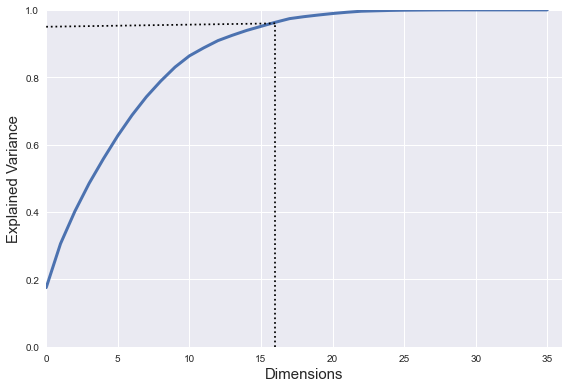

In [74]:
plt.axis([0, 36, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.96], "k:")
plt.plot([0, d], [0.95, 0.96], "k:")
plt.tight_layout()
plt.show()

> Using PCA can reduce the data by 6 dimensions while preserving the whole variance.

### 13. Logistic Regression

> Before PCA:

In [75]:
display_evaluation(y_val, log_reg_pred_9)

F1 Score: 0.89414
Accuracy: 0.89409 



> After PCA:

In [76]:
pca_log_reg = Pipeline([
    ("pca", PCA()),
    ("log_reg", LogisticRegression(random_state=42, max_iter=400, n_jobs=-1))
])

param_grid = [{
    "pca__n_components": [0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
}]

grid_search(pca_log_reg, param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

F1: 0.84511, Accuracy: 0.84582, {'pca__n_components': 0.89}
F1: 0.84511, Accuracy: 0.84582, {'pca__n_components': 0.9}
F1: 0.88237, Accuracy: 0.88199, {'pca__n_components': 0.91}
F1: 0.88237, Accuracy: 0.88199, {'pca__n_components': 0.92}
F1: 0.88189, Accuracy: 0.8816, {'pca__n_components': 0.93}
F1: 0.88172, Accuracy: 0.88147, {'pca__n_components': 0.94}
F1: 0.88172, Accuracy: 0.88147, {'pca__n_components': 0.95}
F1: 0.87813, Accuracy: 0.87783, {'pca__n_components': 0.96}
F1: 0.87775, Accuracy: 0.87744, {'pca__n_components': 0.97}
F1: 0.8771, Accuracy: 0.87679, {'pca__n_components': 0.98}
F1: 0.87663, Accuracy: 0.87653, {'pca__n_components': 0.99}


### 14. Random Forest

> Random Forest before PCA:

In [77]:
display_evaluation(y_val, rf_pred_12)

F1 Score: 0.90089
Accuracy: 0.90099 



> Random Forest after PCA:

In [78]:
pca_rf_clf = Pipeline([
    ("pca", PCA()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

grid_search(pca_rf_clf, param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

F1: 0.91331, Accuracy: 0.91348, {'pca__n_components': 0.89}
F1: 0.91331, Accuracy: 0.91348, {'pca__n_components': 0.9}
F1: 0.93696, Accuracy: 0.93703, {'pca__n_components': 0.91}
F1: 0.93696, Accuracy: 0.93703, {'pca__n_components': 0.92}
F1: 0.93566, Accuracy: 0.93573, {'pca__n_components': 0.93}
F1: 0.93842, Accuracy: 0.93846, {'pca__n_components': 0.94}
F1: 0.93842, Accuracy: 0.93846, {'pca__n_components': 0.95}
F1: 0.94069, Accuracy: 0.9408, {'pca__n_components': 0.96}
F1: 0.94003, Accuracy: 0.94015, {'pca__n_components': 0.97}
F1: 0.94437, Accuracy: 0.94444, {'pca__n_components': 0.98}
F1: 0.94629, Accuracy: 0.9464, {'pca__n_components': 0.99}


In [79]:
d = np.argmax(cumsum >= 0.91) + 1
d

14

> Conclusion:
* We can achieve nearly the same score with PCA, reducing features from 36 to 14.
* The F1 and accuracy scores drop below 0.91 explained variance.

In [80]:
# add PCA to pipeline
full_pipeline.steps.append(('pca', PCA(n_components=0.91)))
full_pipeline

Pipeline(steps=[('feat_adder',
                 CombinedFeaturesAdder(combine_position_wrist=True)),
                ('drop',
                 DropColumns(col_names=['time', 'velocity_x_left',
                                        'velocity_y_left', 'velocity_z_left',
                                        'velocity_x_right', 'velocity_y_right',
                                        'velocity_z_right'])),
                ('std_scl', StandardScaler()),
                ('pca', PCA(n_components=0.91))])

In [81]:
X_train_reduced = full_pipeline.fit_transform(X_train)
X_val_reduced = full_pipeline.transform(X_val)

### 15. KNN:

In [82]:
knn.fit(X_train_reduced, y_train)
knn_pred_15 = knn.predict(X_val_reduced)
display_evaluation(y_val, knn_pred_15)

F1 Score: 0.90371
Accuracy: 0.90398 



### 16. Decision Tree:

In [83]:
tree_clf.fit(X_train_reduced, y_train)
tree_pred_16 = tree_clf.predict(X_val_reduced)
display_evaluation(y_val, tree_pred_16)

F1 Score: 0.86824
Accuracy: 0.86807 



### 17. AdaBoost

In [84]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=42)
ada_clf.fit(X_train_reduced, y_train)
ada_pred_17 = ada_clf.predict(X_val_reduced)
display_evaluation(y_val, ada_pred_17)

F1 Score: 0.86998
Accuracy: 0.86924 



### 18. XGBoost

In [85]:
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
                        num_class=3, use_label_encoder=False)
xgb_clf.fit(X_train_reduced, y_train)
xgb_pred_18 = xgb_clf.predict(X_val_reduced)
display_evaluation(y_val, xgb_pred_18)

F1 Score: 0.94688
Accuracy: 0.94692 



> #### Looking Back:
* The best models (from lowest to highest scores): Logistic Regression, KNN, Random Forest and XGBoost.
* Decision Tree and AdaBoost models had the lowest performance, with 86% F1 and accuracy scores.
>
> The pre-processing steps and baseline models have been analyzed.
> The next step is to find the finest hyperparameters for the best models.

### Fine-Tune Logistic Regression

In [86]:
log_reg.fit(X_train_reduced, y_train)
log_reg_pred = log_reg.predict(X_val_reduced)
display_evaluation(y_val, log_reg_pred)

F1 Score: 0.88237
Accuracy: 0.88199 



> * When the Logistic Regression parameter 'multi_class' is set to 'multinomial', it is using Softmax Regression
which is optimized for multi-class inputs. Simply put, it estimates the probability that an instance belongs
to each class and predicts the highest one. The sum of all probabilities is equal to 1.
* Another approach: One-vs-One and One-vs-Rest wrapper methods.
>
> I'll search for the best hyperparameters, then try applying the best estimator with the wrapper methods.

> Tuning solver and penalty:

In [87]:
# lbfgs - default sklearn solver
# both lbfgs and newton-cg work well with smaller datasets

# both sag and saga solvers work well with large datasets
# they are a variation of gradient descent
# convergence is faster when the data is scaled
# sag = stochastic average gradient, saga = variant of sag solver

param_grid = [
    {"solver": ["lbfgs", "newton-cg", "sag", "saga"]}
]

log_reg = LogisticRegression(multi_class='multinomial', max_iter=400, random_state=42, n_jobs=-1)
grid_search(log_reg, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.88237, Accuracy: 0.88199, {'solver': 'lbfgs'}
F1: 0.88237, Accuracy: 0.88199, {'solver': 'newton-cg'}
F1: 0.88237, Accuracy: 0.88199, {'solver': 'sag'}
F1: 0.88237, Accuracy: 0.88199, {'solver': 'saga'}


> Tuning the regularization strength:

In [88]:
param_grid = [{
    "C": [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1.]  # C controls regularization,
    # light penalty if close to 1.0, strong penalty if close to 0.0
}]

grid_search(log_reg, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.88054, Accuracy: 0.88043, {'C': 0.001, 'solver': 'lbfgs'}
F1: 0.88227, Accuracy: 0.88199, {'C': 0.01, 'solver': 'lbfgs'}
F1: 0.88273, Accuracy: 0.88238, {'C': 0.1, 'solver': 'lbfgs'}
F1: 0.88236, Accuracy: 0.88199, {'C': 0.2, 'solver': 'lbfgs'}
F1: 0.88237, Accuracy: 0.88199, {'C': 0.5, 'solver': 'lbfgs'}
F1: 0.88237, Accuracy: 0.88199, {'C': 0.8, 'solver': 'lbfgs'}
F1: 0.88237, Accuracy: 0.88199, {'C': 1.0, 'solver': 'lbfgs'}


> **Final Logistic Regression model:** Lbfgs solver, l2 norm and 0.1 penalty.

In [89]:
log_reg_final = LogisticRegression(multi_class='multinomial', C=0.1, random_state=42, n_jobs=-1)
log_reg_final.fit(X_train_reduced, y_train)
log_reg_final_pred = log_reg_final.predict(X_val_reduced)
display_evaluation(y_val, log_reg_final_pred)

F1 Score: 0.88273
Accuracy: 0.88238 



### Fine-Tune KNN

In [90]:
display_evaluation(y_val, knn_pred_15)

F1 Score: 0.90371
Accuracy: 0.90398 



> Tuning weights and penalty:

In [91]:
param_grid = [{
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}]

grid_search(knn, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.90353, Accuracy: 0.90385, {'p': 1, 'weights': 'uniform'}
F1: 0.90367, Accuracy: 0.90398, {'p': 1, 'weights': 'distance'}
F1: 0.90371, Accuracy: 0.90398, {'p': 2, 'weights': 'uniform'}
F1: 0.90371, Accuracy: 0.90398, {'p': 2, 'weights': 'distance'}


> Tuning number of neighbors:
>> Note: There is an odd number of classes. It is better to choose an even number of neighbors to
>> prevent ties.

In [92]:
param_grid = [{
    "weights": ["distance"],
    "p": [1],
    "n_neighbors": [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
}]

grid_search(knn, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.90048, Accuracy: 0.90086, {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
F1: 0.90221, Accuracy: 0.90255, {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
F1: 0.90326, Accuracy: 0.90359, {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
F1: 0.90326, Accuracy: 0.90359, {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
F1: 0.90438, Accuracy: 0.90476, {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
F1: 0.90633, Accuracy: 0.90671, {'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
F1: 0.90778, Accuracy: 0.90814, {'n_neighbors': 14, 'p': 1, 'weights': 'distance'}
F1: 0.90791, Accuracy: 0.90827, {'n_neighbors': 16, 'p': 1, 'weights': 'distance'}
F1: 0.9095, Accuracy: 0.90984, {'n_neighbors': 18, 'p': 1, 'weights': 'distance'}
F1: 0.91186, Accuracy: 0.91218, {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
F1: 0.91342, Accuracy: 0.91374, {'n_neighbors': 22, 'p': 1, 'weights': 'distance'}
F1: 0.91461, Accuracy: 0.91491, {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
F1: 0.915

> **Final KNN model:** Distance weights, l1 norm and 20 neighbors.
>> Note: The final KNN model has a higher accuracy than the final Logistic Regression model!

In [93]:
knn_final = KNeighborsClassifier(weights= "distance", p=1, n_neighbors=20, n_jobs=-1)
knn_final.fit(X_train_reduced, y_train)
knn_final_pred = knn_final.predict(X_val_reduced)
display_evaluation(y_val, knn_final_pred)

F1 Score: 0.91186
Accuracy: 0.91218 



### Fine-Tune Random Forest

In [94]:
rf_clf.fit(X_train_reduced, y_train)
rf_clf_pred = rf_clf.predict(X_val_reduced)
display_evaluation(y_val, rf_clf_pred)

F1 Score: 0.93696
Accuracy: 0.93703 



> Tuning maximum number features per tree:
>> Note: If this hyperparameter is set to 'None', it evaluates all features. When dealing with high
> dimensional data (such as image classification) it can be convenient to select a smaller amount
> of features.

In [95]:
param_grid = [{
    "max_features": ['sqrt', "log2", 0.1, 0.2, 0.5, 0.8, None]  # max features that are evaluated before splitting a node
}]

grid_search(rf_clf, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.93696, Accuracy: 0.93703, {'max_features': 'sqrt'}
F1: 0.93696, Accuracy: 0.93703, {'max_features': 'log2'}
F1: 0.94275, Accuracy: 0.94288, {'max_features': 0.1}
F1: 0.93148, Accuracy: 0.93156, {'max_features': 0.2}
F1: 0.92657, Accuracy: 0.92662, {'max_features': 0.5}
F1: 0.91769, Accuracy: 0.91764, {'max_features': 0.8}
F1: 0.90485, Accuracy: 0.90476, {'max_features': None}


> Tuning number of trees with Bagging and Pasting:
>> Note: More estimators tend to improve accuracy at the expense of increasing the computation time.
> Additionally, from a certain amount of trees the model performance does not change much.

In [96]:
param_grid = [{
    "max_features":[0.1],
    "n_estimators": [50, 100, 200], # number of trees in the forest
    "bootstrap": [True, False], # sampling with or without replacement
    # True (sklearn default) = bagging, False = pasting
    "criterion": ["gini", "entropy"] # function to measure quality of split
}]

grid_search(rf_clf, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.94041, Accuracy: 0.94054, {'bootstrap': True, 'criterion': 'gini', 'max_features': 0.1, 'n_estimators': 50}
F1: 0.94275, Accuracy: 0.94288, {'bootstrap': True, 'criterion': 'gini', 'max_features': 0.1, 'n_estimators': 100}
F1: 0.9463, Accuracy: 0.9464, {'bootstrap': True, 'criterion': 'gini', 'max_features': 0.1, 'n_estimators': 200}
F1: 0.93965, Accuracy: 0.93976, {'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.1, 'n_estimators': 50}
F1: 0.94266, Accuracy: 0.94275, {'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.1, 'n_estimators': 100}
F1: 0.94424, Accuracy: 0.94431, {'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.1, 'n_estimators': 200}
F1: 0.94016, Accuracy: 0.94028, {'bootstrap': False, 'criterion': 'gini', 'max_features': 0.1, 'n_estimators': 50}
F1: 0.93949, Accuracy: 0.93963, {'bootstrap': False, 'criterion': 'gini', 'max_features': 0.1, 'n_estimators': 100}
F1: 0.94055, Accuracy: 0.94067, {'bootstrap': False, 'criterion': 'gini', 

> **Final Random Forest model:** 200 estimators, bagging method (sampling with replacement), entropy criterion,
> and considers 0.1 amount of features when splitting a node.

In [97]:
rf_clf_final = RandomForestClassifier(n_estimators=200, criterion="entropy", max_features=0.1,
                                      random_state=42, n_jobs=-1)
rf_clf_final.fit(X_train_reduced, y_train)
rf_clf_final_pred = rf_clf_final.predict(X_val_reduced)
display_evaluation(y_val, rf_clf_final_pred)

F1 Score: 0.94424
Accuracy: 0.94431 



### Fine-Tune XGBoost

In [98]:
display_evaluation(y_val, xgb_pred_18)

F1 Score: 0.94688
Accuracy: 0.94692 



> Tuning the number of estimators:

In [99]:
eval_set = [(X_train_reduced, y_train), (X_val_reduced, y_val)]
xgb_clf2 = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
                        num_class=3, use_label_encoder=False)
xgb_clf2.fit(X_train_reduced, y_train, eval_set=eval_set, eval_metric="merror", early_stopping_rounds=10, verbose=False)
xgb_pred2 = xgb_clf2.predict(X_val_reduced)
display_evaluation(y_val, xgb_pred2)

F1 Score: 0.95367
Accuracy: 0.95381 



In [100]:
xgb_clf2.best_iteration

51

In [101]:
1-xgb_clf2.best_score

0.953812

> Tuning learning rate and tree depth:

In [115]:
param_grid = [{
    "n_estimators": [52],
    "max_depth": [4, 6, 10],  # maximum depth of a tree
    "learning_rate": [0.2, 0.5, 0.8, 1.]  # controls the weights after every boost (eta)
}]

grid_search(xgb_clf2, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

F1: 0.93532, Accuracy: 0.93547, {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 52}
F1: 0.94593, Accuracy: 0.94614, {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 52}
F1: 0.93716, Accuracy: 0.93729, {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 52}
F1: 0.95155, Accuracy: 0.9516, {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 52}
F1: 0.94883, Accuracy: 0.94887, {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 52}


KeyboardInterrupt: 

In [ ]:
param_grid = [{
    "n_estimators": [52],
    "max_depth": [3, 4, 5],  # maximum depth of a tree
    "learning_rate": [0.5]  # controls the weights after every boost (eta)
}]

grid_search(xgb_clf2, param_grid, X_train_reduced, y_train, X_val_reduced, y_val)

> **Final XGBoost model:** 0.5 learning rate, maximum tree depth 4.

In [ ]:
xgb_clf_final = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
                        num_class=3, use_label_encoder=False, max_depth=4, learning_rate=0.5, n_estimators=52)
xgb_clf_final.fit(X_train_reduced, y_train)
xgb_clf_final_pred = xgb_clf_final.predict(X_val_reduced)
display_evaluation(y_val, xgb_clf_final_pred)

### Voting Classifiers
> The voting classifier is an ensemble that aggregates the predictions of multiple classifiers.
> This often leads to higher prediction accuracy.
>> Note: This does not guarantee that the voting classifier will achieve higher accuracy.
> The classifiers were trained on the same data and might make similar errors, so it is preferable
> to use classifiers with diverse algorithms.

> ### Hard Voting Classifier:
> Predicts the class that received the most votes.

In [106]:
voting_hard = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg_final)),
        ('knn', clone(knn_final)),
        ('rf', clone(rf_clf_final)),
        ('xgb', clone(xgb_clf_final))],
    weights=[1, 2, 3, 4],
    voting='hard')

voting_hard.fit(X_train_reduced, y_train)
voting_hard_pred = voting_hard.predict(X_val_reduced)
display_evaluation(y_val, voting_hard_pred)

F1 Score: 0.94949
Accuracy: 0.94952 



> ### Soft Voting Classifier:
> Averages the predicted probabilities.
>> Note: This voting method is only possible when all classifiers can output predicted probabilities.

In [107]:
voting_soft = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg_final)),
        ('rf', clone(rf_clf_final)),
        ('xgb', clone(xgb_clf_final))],
    voting='soft')

voting_soft.fit(X_train_reduced, y_train)
voting_soft_pred = voting_soft.predict(X_val_reduced)
display_evaluation(y_val, voting_soft_pred)

F1 Score: 0.94931
Accuracy: 0.94939 



In [108]:
X_test = test_set.drop("state", axis=1)
y_test = test_set.state.copy()
X_test_prepared = full_pipeline.transform(X_test)
pred = xgb_clf.predict(X_test_prepared)
display_evaluation(y_test, pred)

F1 Score: 0.8635
Accuracy: 0.86567 



### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Yozevitch, Roi & Gvirts Problovski, Hila & Apelboim, Ornit & Mishraky, Elhanan. (2018). Harnessing Machine Learning for interpersonal physical alignment. 1-4. 10.1109/ICSEE.2018.8646075.
2. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

----

keep_same = {"state", "time"}
df_shift.columns = df_shift.columns.map(lambda x: x if x in keep_same else x + "_shift")
df.merge(df_shift, on=["state", "time"]).dropna()

df1 = df.groupby("time").apply(lambda df: df.reset_index(drop=True)).unstack().sort_index(axis=1, level=1).reset_index()
df1

df1.columns = df1.columns.droplevel(1)

df1
#df1.elbow_pos_x_left

2. Train the model using the data of one person and evaluate with the second, then train the first two
people and evaluate with the third, and so on.

# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, combine_position_wrist=False):
        self.combine_position_wrist = combine_position_wrist

    def fit(self, X, y=None):
        return self # no fitting needed

    def transform(self, X):
        mean_pos_x_left = (X["wrist_pos_x_left"] + X["position_x_left"]) / 2
        mean_pos_y_left = (X["wrist_pos_y_left"] + X["position_y_left"]) / 2
        mean_pos_z_left = (X["wrist_pos_z_left"] + X["position_z_left"]) / 2
        mean_pos_x_right = (X["wrist_pos_x_right"] + X["position_x_right"]) / 2
        mean_pos_y_right = (X["wrist_pos_y_right"] + X["position_y_right"]) / 2
        mean_pos_z_right = (X["wrist_pos_z_right"] + X["position_z_right"]) / 2
        if self.combine_position_wrist:
            # np.c_ concatenates slice objects along the second axis
            return np.c_[X, mean_pos_x_left, mean_pos_y_left, mean_pos_z_left,
                         mean_pos_x_right, mean_pos_y_right, mean_pos_z_right]
        return X.to_numpy() # return also in numpy format

# custom transformer drops features from dataframe
class DropColumns(TransformerMixin, BaseEstimator):

    def __init__(self, col_names=None):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.col_names is not None:
            return X.drop(self.col_names, axis=1)
        return X

-----

drop_cols = train.filter(regex="time|velocity|position|wrist_pos").columns.tolist() # get list with column names
full_pipeline["drop"].__setattr__("col_names", drop_cols) # set transformer hyperparameter with new list
full_pipeline.steps # check that the hyperparameter changed

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

### 13. Logistic Regression

log_reg = LogisticRegression(random_state=42, n_jobs=-1)
log_reg.fit(X_train_prepared, y_train)
log_reg_pred_13 = log_reg.predict(X_val_prepared)
display_evaluation(y_val, log_reg_pred_13)
log_reg_scores.append(return_scores(y_val, log_reg_pred_13))

### 14. KNN

# uniform weights
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_prepared, y_train)
knn_pred_14 = knn.predict(X_val_prepared)
display_evaluation(y_val, knn_pred_14)
knn_scores.append(return_scores(y_val, knn_pred_14))

### 15. Decision Tree Classifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_prepared, y_train)
tree_pred_15 = tree_clf.predict(X_val_prepared)
display_evaluation(y_val, tree_pred_15)
tree_scores.append(return_scores(y_val, tree_pred_15))

### 16. Random Forest Classifier

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_prepared, y_train)
rf_pred_16 = rf_clf.predict(X_val_prepared)
display_evaluation(y_val, rf_pred_16)
rf_scores.append(return_scores(y_val, rf_pred_16))


From looking at the results, the highest score for most models was the third round with the added features
and the old features. Only the Random Forest model improved when the position and wrist features were
removed.

----